In [52]:
import rasterio
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import matplotlib.pyplot as plt
import os
import pandas as pd
import xarray as xr

In [18]:
files_dir = "../Data/Soil Moisture/SMAP_3dayComposite_smi"
# os.listdir(files_dir)
files = []
for file in os.listdir(files_dir):
    if file.endswith(".tif"):
        files.append(os.path.join(files_dir,file))
files.sort()

In [19]:
type(files)

list

In [20]:
stack_output_path = "../Data/Soil Moisture"
stack_output_file = os.path.join(stack_output_path, "smap_smi_stack.tif")
smi_stack, smi_meta = es.stack(files, stack_output_file)

In [21]:
smi_stack.shape

(1729, 256, 272)

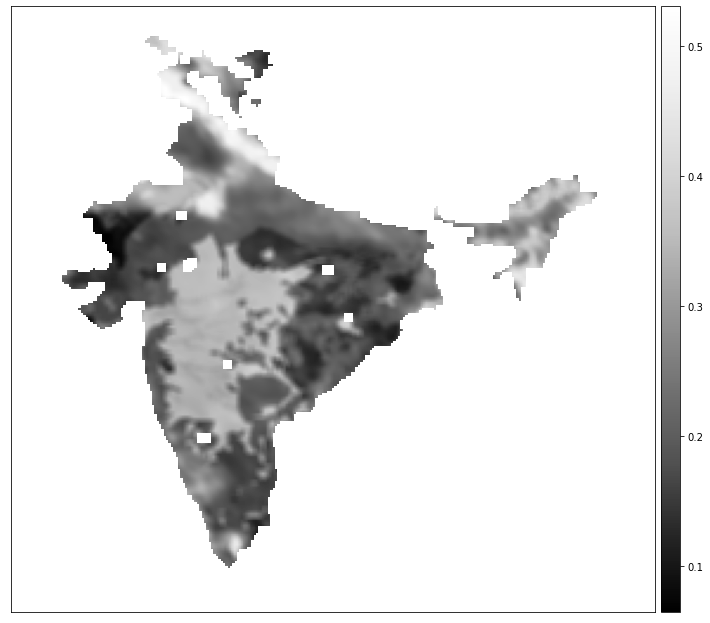

In [53]:
ep.plot_bands(smi_stack[0])
plt.show()

In [46]:
# https://stackoverflow.com/questions/46899337/convert-raster-time-series-of-multiple-geotiff-images-to-netcdf

def time_index_from_filenames(filenames):
    '''helper function to create a pandas DatetimeIndex
       Filename example: 20150520_0164.tif'''
    return pd.DatetimeIndex([pd.Timestamp(f[64:72]) for f in filenames])

time = xr.Variable('time', time_index_from_filenames(files))
chunks = {'x': 256, 'y': 272, 'band': 1}
da = xr.concat([xr.open_rasterio(f, chunks=chunks) for f in files], dim=time)

In [47]:
da

,Array,Chunk
Bytes,481.57 MB,262.14 kB
Shape,"(1729, 1, 256, 272)","(1, 1, 256, 256)"
Count,12103 Tasks,3458 Chunks
Type,float32,numpy.ndarray


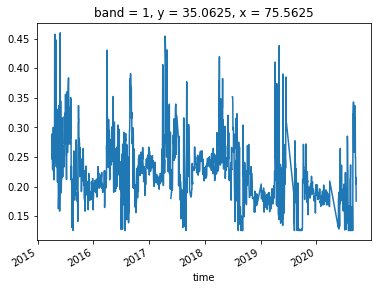

In [71]:
ts = da.isel(x=76, y=23)
ts.plot()

In [55]:
import gdal

In [57]:
gdal.TranslateOptions

<function osgeo.gdal.TranslateOptions(options=None, format=None, outputType=0, bandList=None, maskBand=None, width=0, height=0, widthPct=0.0, heightPct=0.0, xRes=0.0, yRes=0.0, creationOptions=None, srcWin=None, projWin=None, projWinSRS=None, strict=False, unscale=False, scaleParams=None, exponents=None, outputBounds=None, metadataOptions=None, outputSRS=None, nogcp=False, GCPs=None, noData=None, rgbExpand=None, stats=False, rat=True, resampleAlg=None, callback=None, callback_data=None)>

In [72]:
tif_file = "../Data/Soil Moisture/smap_smi_stack.tif"
out_filename = "../Data/Soil Moisture/smap_smi_stack.nc"
# Input Raster File
smi_raster = gdal.Open(tif_file)
# Save Multiband Raster as a NetCDF 
gdal.Translate(out_filename, smi_raster)

In [73]:
import rioxarray as rxr

In [76]:
smi = xr.open_dataset(out_filename)

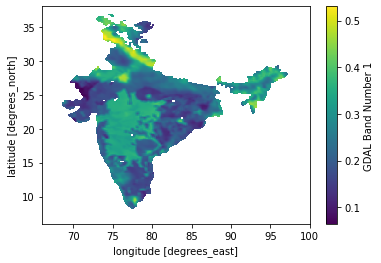

In [78]:
smi.Band1.plot()

In [79]:
smi_raster = xr.open_rasterio('../Data/Soil Moisture/smap_smi_stack.tif')

In [84]:
# https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html

import fiona
import rasterio.mask

with fiona.open("../Data/Bandipur Shapefile/Bandipur.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open("../Data/Soil Moisture/smap_smi_stack.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

In [94]:
import geopandas as gpd
shp = gpd.read_file("../Data/Bandipur Shapefile/Bandipur.shp")

Text(0.5, 1.0, 'Shapefile Crop Extent')

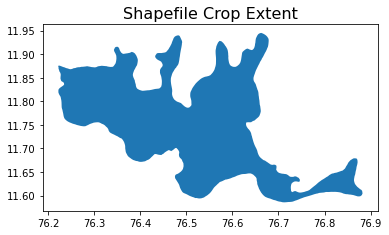

In [117]:
# Plot the crop boundary layer
fig, ax = plt.subplots(figsize=(6, 6))

shp.plot(ax=ax)

ax.set_title("Shapefile Crop Extent",
             fontsize=16)

In [97]:
raster = rasterio.open(tif_file)

In [107]:
raster_crop = es.crop_image(raster, shp)

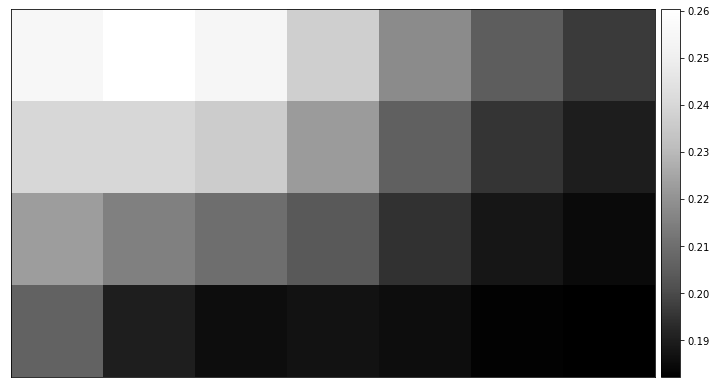

<AxesSubplot:>

In [112]:
ep.plot_bands(raster_crop[0][0])


### Resources - Geospatial Libraries for Python

* https://github.com/giswqs/python-geospatial
* Google Search - installing geospatial libraries python


##### Geotiffs to NetCDF using GDAL Translate
* https://gdal.org/python/osgeo.gdal-module.html#TranslateOptions
* https://gis.stackexchange.com/questions/352643/gdal-translate-in-python-where-do-i-find-how-to-convert-the-command-line-argum
* https://gis.stackexchange.com/questions/199570/how-to-prepare-tiffs-to-create-a-netcdf-file

##### Raster Masking - AOI Extraction
* https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/
* https://mygeoblog.com/2019/06/25/mask-netcdf-using-shp-file/
* https://corteva.github.io/rioxarray/stable/examples/clip_geom.html
* https://gis.stackexchange.com/questions/289775/masking-netcdf-data-using-shapefile-xarray-geopandas

##### Raster Resampling using GDAL/Rasterio
* https://stackoverflow.com/questions/62988817/resample-image-rasterio-gdal-python


##### Data Visualisation - Plot Rasters 
* https://automating-gis-processes.github.io/CSC18/lessons/L6/plotting-raster.html

##### Batch Downloading Sentinel Data
* http://un-spider.org/links-and-resources/data-sources/batch-download-sentinel


##### Xarray Fundamentals
* https://rabernat.github.io/research_computing_2018/xarray.html
* http://xarray.pydata.org/en/stable/plotting.html

#### Remote Sensing Introductory Tutorials
* https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/landsat-in-Python/
